In [1]:
%load_ext autoreload
%autoreload 2
from lib.model import train_lgbm_fold_classif, plot_importances
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from lib.constants import DATA_FOLDER, TMP_FOLDER, SUBMISSION_FOLDER
from lib.dataload import load_data
import numpy as np
from lib.utils import make_submission_from_hdf
df_train, df_target, df_test = load_data(read=True, reduce_mem=False)
df_train['is_train'] = 1
df_test['is_train'] = 0
train_test = pd.concat([df_train, df_test], sort=False)

/Users/benjaminfarcy/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


... Reading ...
-- Done


In [2]:
nmods_data = []
for param in train_test.columns:
    nmods = train_test[param].nunique()
    nmods_data.append(nmods)

df_nmods = pd.DataFrame(list(train_test.columns), columns=['param'])
df_nmods['nmods'] = nmods_data

sel_cols = list(set(df_nmods.columns) - set(['is_train', 'target']))

look_cols = list(df_nmods[sel_cols].sort_values('nmods').head(30)['param'].values[2:])

In [3]:
count_cols = []
for col in look_cols:
    colname = 'count_' + col
    count_cols.append(colname)
    tmp = (
        pd.DataFrame(train_test.groupby([col])['ID_code']
                     .count().reset_index()
                     .rename(columns={'ID_code': colname}))
    )
    train_test = train_test.merge(tmp, on=[col])

In [4]:
for col in count_cols:
    df_a = pd.cut(train_test[col], train_test[col].nunique()).value_counts().sort_index()
    df_a = df_a.reset_index().rename(columns={'index': 'bin'}).reset_index()
    df_a['diff'] = df_a[col].diff().fillna(0)
    df_a['delta_0'] = np.around((df_a[col] - 0 )/ (df_a['index'] + 1), decimals=0)
    
    step = (train_test[col].max()-train_test[col].min())/train_test[col].nunique()
    tmp2 = pd.DataFrame(train_test[col].drop_duplicates()).sort_values(by=col)
    group_col = 'group_' + col
    tmp2[group_col] = tmp2[col].apply(lambda x: int(df_a.iloc[np.minimum(int(x/step),
                                                  train_test[col].nunique()-1), 4]))
    train_test = train_test.merge(tmp2, on=col)

In [11]:
remove_cols = ['target', 'ID_code', 'is_train']
selected_cols = list(set(df_train.columns) - set(remove_cols))
print(selected_cols)

['var_42', 'var_133', 'var_113', 'var_14', 'var_141', 'var_37', 'var_91', 'var_184', 'var_77', 'var_8', 'var_199', 'var_2', 'var_49', 'var_118', 'var_128', 'var_45', 'var_66', 'var_180', 'var_196', 'var_23', 'var_170', 'var_139', 'var_156', 'var_174', 'var_159', 'var_10', 'var_5', 'var_47', 'var_160', 'var_36', 'var_16', 'var_52', 'var_81', 'var_87', 'var_51', 'var_33', 'var_117', 'var_151', 'var_125', 'var_59', 'var_35', 'var_143', 'var_112', 'var_134', 'var_166', 'var_121', 'var_122', 'var_153', 'var_74', 'var_140', 'var_53', 'var_162', 'var_93', 'var_157', 'var_88', 'var_108', 'var_123', 'var_19', 'var_131', 'var_119', 'var_173', 'var_161', 'var_12', 'var_48', 'var_107', 'var_13', 'var_179', 'var_97', 'var_34', 'var_176', 'var_175', 'var_190', 'var_71', 'var_185', 'var_198', 'var_41', 'var_147', 'var_76', 'var_111', 'var_163', 'var_120', 'var_85', 'var_99', 'var_46', 'var_142', 'var_103', 'var_20', 'var_7', 'var_11', 'var_95', 'var_168', 'var_152', 'var_17', 'var_96', 'var_65', 'var

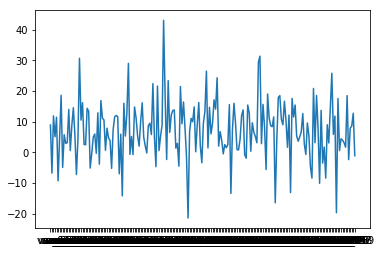

In [16]:
plt.plot(df_train.iloc[0, 2:-1])

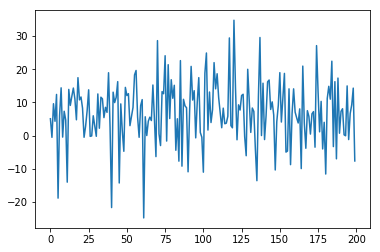

In [38]:
plt.plot(np.arange(0, 200), df_train.iloc[10, 2:-1])

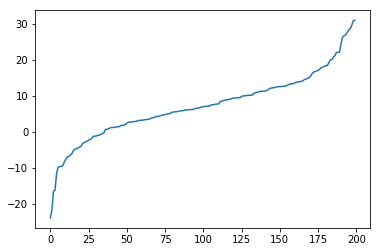

In [72]:
plt.plot(np.arange(0, 200), df_train.iloc[100, 2:-1].sort_values())

/Users/benjaminfarcy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  """


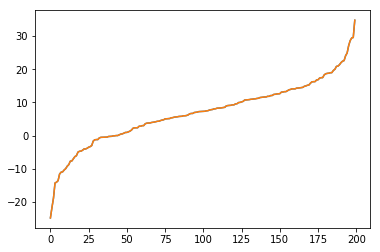

In [80]:
from scipy.interpolate import spline, CubicSpline
from scipy.interpolate import UnivariateSpline
xk = spline(np.arange(0, 200).astype('float'),
       df_train.iloc[10, 2:-1].sort_values().values.astype('float'),
       np.arange(0, 200).astype('float')
      )
plt.plot(np.arange(0, 200), xk)
plt.plot(np.arange(0, 200), df_train.iloc[10, 2:-1].sort_values())

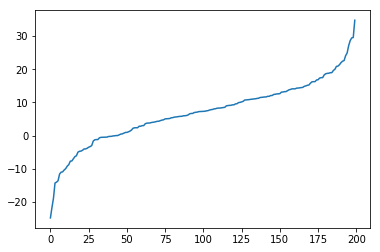

In [79]:
cs = CubicSpline(np.arange(0, 200).astype('float'), df_train.iloc[10, 2:-1].sort_values().values.astype('float'))
plt.plot(np.arange(0, 200), cs(np.arange(0, 200)))

In [162]:
data_dict = {}
data_dict['integral'] = []
data_dict['residual'] = []
data_dict['left_derivative'] = []
data_dict['center_derivative'] = []
data_dict['right_derivative'] = []

lent = len(train_test)
sub_train_test = train_test[selected_cols]
for index, row in enumerate(range(lent)):
    us = UnivariateSpline(np.arange(0, 200).astype('float'),
                      sub_train_test.iloc[row, :].sort_values().values.astype('float'),
                      k=5
                     )
    data_dict['integral'].append(us.integral(0, 199))
    data_dict['residual'].append(us.get_residual())
    data_dict['left_derivative'].append(us.derivatives(10)[1])
    data_dict['center_derivative'].append(us.derivatives(100)[1])
    data_dict['right_derivative'].append(us.derivatives(189)[1])
    if index % 5000 == 0:
        print(index/lent*100)

0.0
1.25
2.5
3.75
5.0
6.25
7.5
8.75
10.0
11.25
12.5
13.750000000000002
15.0
16.25
17.5
18.75
20.0
21.25
22.5
23.75
25.0
26.25
27.500000000000004
28.749999999999996
30.0
31.25
32.5
33.75
35.0
36.25
37.5
38.75
40.0
41.25
42.5
43.75
45.0
46.25
47.5
48.75
50.0
51.24999999999999
52.5
53.75
55.00000000000001
56.25
57.49999999999999
58.75
60.0
61.25000000000001
62.5
63.74999999999999
65.0
66.25
67.5
68.75
70.0
71.25
72.5
73.75
75.0
76.25
77.5
78.75
80.0
81.25
82.5
83.75
85.0
86.25
87.5
88.75
90.0
91.25
92.5
93.75
95.0
96.25
97.5
98.75


In [166]:
tmp = train_test.merge(pd.DataFrame(data_dict), on=train_test.index)
tmp.shape

(400000, 270)

In [167]:
tmp.head()

,key_0,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,...,min_col,max_col,std_col,var_col,mean_col,integral,residual,left_derivative,center_derivative,right_derivative
0,0,train_0,0.0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,...,-21.4494,43.1127,9.331540,87.077642,7.281591,1448.580491,199.963746,0.708200,0.150010,0.751476
1,1,train_27065,0.0,9.1238,0.8218,12.2922,7.4955,13.5695,-4.0594,4.7226,...,-33.1639,29.5604,9.225221,85.104701,6.316245,1261.014867,200.105892,0.833292,0.097149,0.547775
2,2,test_127606,NaN,8.2181,-6.0042,13.6066,4.7298,12.4819,1.0450,3.9583,...,-47.0036,48.2699,10.765215,115.889864,6.942421,1387.546189,200.011336,0.344922,0.083031,1.099548
3,3,train_100188,0.0,16.2095,-3.2214,10.8693,10.0596,12.1550,-6.1441,4.9091,...,-45.2990,39.1631,10.055402,101.111105,7.371821,1476.091683,200.002649,0.504945,0.115861,0.804896
4,4,test_69381,NaN,12.7847,-7.0814,7.4734,9.3694,12.3327,12.9542,4.9335,...,-20.9969,32.7490,8.544993,73.016899,6.749280,1342.679999,118.866067,0.564681,0.131212,0.596458


In [164]:
pd.DataFrame(data_dict).head()

,integral,residual,left_derivative,center_derivative,right_derivative
0,1448.580491,199.963746,0.708200,0.150010,0.751476
1,1261.014867,200.105892,0.833292,0.097149,0.547775
2,1387.546189,200.011336,0.344922,0.083031,1.099548
3,1476.091683,200.002649,0.504945,0.115861,0.804896
4,1342.679999,118.866067,0.564681,0.131212,0.596458


In [46]:
# columnwise features
train_test['min_col'] = train_test[selected_cols].min(axis=1)
train_test['max_col'] = train_test[selected_cols].max(axis=1)
train_test['std_col'] = train_test[selected_cols].std(axis=1)
train_test['var_col'] = train_test[selected_cols].var(axis=1)
train_test['mean_col'] = train_test[selected_cols].mean(axis=1)
train_test['median_col'] = train_test[selected_cols].median(axis=1)

In [47]:
print("- Resplit train/test")
train = train_test[train_test['is_train'] == 1]
test = train_test[train_test['is_train'] == 0]

- Resplit train/test


# PCA stuff

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50)
remove_cols = ['target', 'ID_code', 'is_train']
selected_cols = list(set(df_train.columns) - set(remove_cols))
pca_result = pca.fit_transform(train_test[selected_cols])

print(pca.explained_variance_ratio_)  
print(pca.singular_values_)  

print("Total explained variance:", np.sum(pca.explained_variance_ratio_))

plt.scatter(x=pca_result[:, 0], y=pca_result[:, 1], marker='.')

In [ ]:
train_test['pca_0_0'] = np.around(pca_result[:, 0], decimals=0)
train_test['pca_0_1'] = np.around(pca_result[:, 1], decimals=0)

In [ ]:
train_test['pca_0_0'].hist(bins=100)

In [ ]:
sns.jointplot(pca_result[:, 0], pca_result[:, 1], kind="hex", color="#4CB391")

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn import metrics


X = pca_result

# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor=tuple(col), markersize=1)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor=tuple(col), markersize=1)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

# Model

In [168]:
print("- Resplit train/test")
train_test = tmp
train = train_test[train_test['is_train'] == 1]
test = train_test[train_test['is_train'] == 0]

- Resplit train/test


In [ ]:
train.to_hdf('./data_tmp/new_train.hdf', 'df')
test.to_hdf('./data_tmp/new_test.hdf', 'df')

In [171]:
# Code
remove_cols = ['target', 'ID_code']
features = list(set(train.columns) - set(remove_cols) - set(selected_cols))

importances, df_oof_preds, df_preds, filename = train_lgbm_fold_classif(train, test, features, train['target'],
                              repeat_cv=1, n_splits=4,
                              n_max_estimators=10000
                              )

== INIT ==
== START MODEL TRAIN
== REPEAT CV 0
==== CV 0
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.605118	valid_1's auc: 0.595059
[200]	training's auc: 0.619868	valid_1's auc: 0.611392
[300]	training's auc: 0.625187	valid_1's auc: 0.615319
[400]	training's auc: 0.629047	valid_1's auc: 0.618212
[500]	training's auc: 0.631282	valid_1's auc: 0.619786
[600]	training's auc: 0.633144	valid_1's auc: 0.621295
[700]	training's auc: 0.633881	valid_1's auc: 0.621604
[800]	training's auc: 0.635276	valid_1's auc: 0.622422
[900]	training's auc: 0.63664	valid_1's auc: 0.623407
[1000]	training's auc: 0.637415	valid_1's auc: 0.623537
[1100]	training's auc: 0.637869	valid_1's auc: 0.623397
Early stopping, best iteration is:
[1000]	training's auc: 0.637415	valid_1's auc: 0.623537
==== CV 1
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.603883	valid_1's auc: 0.601737
[200]	training's auc: 0.615849	valid_1's auc: 0.616601


4


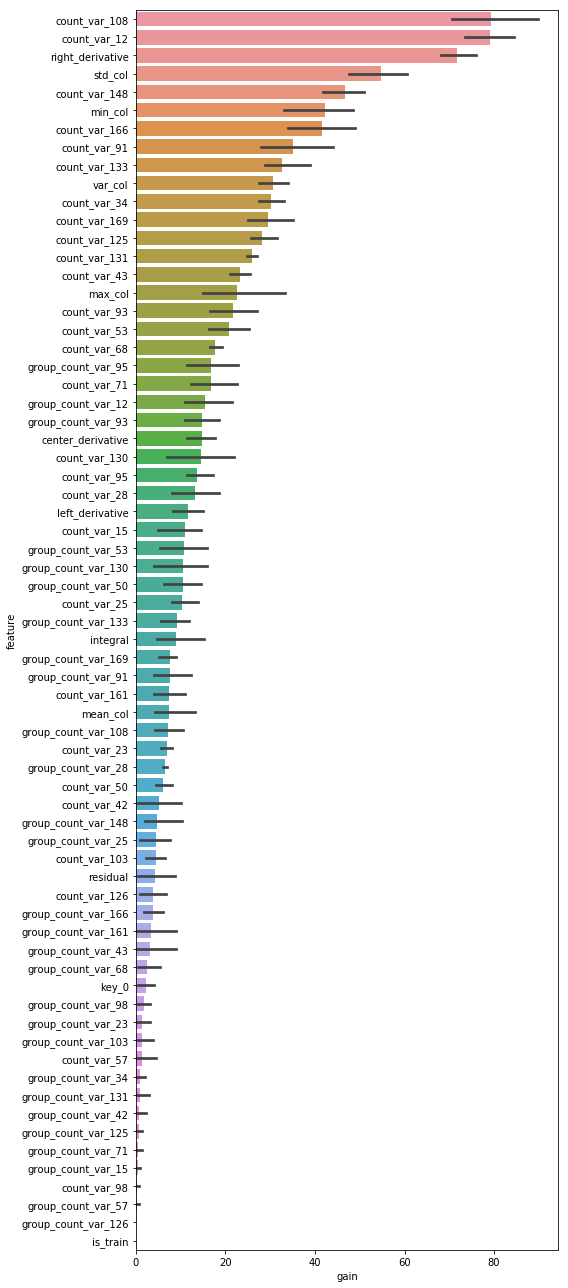

,feature,gain,model,fold,mean_gain
31,count_var_108,74,0,1,79.25
31,count_var_108,67,0,2,79.25
31,count_var_108,81,0,0,79.25
31,count_var_108,95,0,3,79.25
52,count_var_12,72,0,0,79.00
52,count_var_12,75,0,1,79.00
52,count_var_12,87,0,3,79.00
52,count_var_12,82,0,2,79.00
36,right_derivative,78,0,3,71.75
36,right_derivative,70,0,2,71.75


In [172]:
plot_importances(importances, num_features=200)

# Submissions

In [50]:
test['ID_code'].reset_index().head()

,index,ID_code
0,2,test_127606
1,4,test_69381
2,7,test_99014
3,8,test_35882
4,10,test_115968


In [55]:
df_pred_file = df_preds.merge(test['ID_code'].reset_index(), on=df_preds.index)[['ID_code', 0]].rename(columns={0:'target'})
df_pred_file.to_csv('./data_tmp/test_pred.csv', index=False)

In [ ]:
filename = 'preds_lgbm_classif_CV_0.88763_TR_0.98783'
filename = 'preds_lgbm_classif_CV_0.89800_TR_0.91159'


In [51]:
filename

'lgbm_classif_CV_0.89810_TR_0.91029.hdf'

In [57]:
make_submission_from_hdf('preds_lgbm_classif_CV_0.89810_TR_0.91029', test['ID_code'])

,ID_code,target
0,test_127606,0.033140
1,test_69381,0.307902
2,test_99014,0.021587
3,test_35882,0.083922
4,test_115968,0.016019
5,test_173387,0.010261
6,test_15480,0.033571
7,test_193058,0.102876
8,test_142036,0.290642
9,test_134024,0.012523


In [ ]:
preds_lgbm_classif_CV_0.89810_TR_0.91029.hdf